In [1]:
#import shap
import pandas as pd
import scipy as sp
import numpy as np
from irf.ensemble import wrf
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA
import seaborn as sn

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Compare different methods in terms of feature selection using simulated data

In [2]:
### load data

num = 2

problem = [0]
tree_depth = [1]
for num in range(1, 3):
    for problem in ['classification', 'regression']:
        for tree_depth in ['deep', 'shallow']:
            print('working on {} {} {}'.format(num, problem, tree_depth))
            oob_list, gini_list, shap_list, mda_list = [], [], [], []
            for i in range(40):
                X_train = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_X_train.csv'.format(problem, num, i), delimiter=',')
                y_train = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_y_train.csv'.format(problem, num, i), delimiter=',')
                X_test = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_X_test.csv'.format(problem, num, i), delimiter=',')
                y_test = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_y_test.csv'.format(problem, num, i), delimiter=',')
                noisy_features = np.loadtxt('../intermediate/04_aggregate/{}{}/permuted{}_noisy_features.csv'.format(problem, num, i), delimiter=',').astype(np.int)
                n_features = len(noisy_features)

                ### Train RF
                if problem == 'classification':
                    if tree_depth == 'deep':
                        rf = rfc(n_estimators=100, max_features=10, min_samples_leaf=1)
                    else:
                        rf = rfc(n_estimators=100, max_features=10, min_samples_leaf=100)
                else:
                    if tree_depth == 'deep':
                        rf = rfr(n_estimators=100, max_features= 10, min_samples_leaf=1)
                    else:
                        rf = rfr(n_estimators=100, max_features= 10, min_samples_leaf=100)
                rf.fit(X_train, y_train)
                gini_imp = rf.feature_importances_
                if problem == 'classification':
                    y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()
                    oob_imp, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False, balanced = False)
                else:
                    oob_imp, debiased_fi_std = FI(rf, X_train, y_train[:, np.newaxis], type='oob', normalized=False, balanced = False)

                if problem == 'classification':
                    MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=5)
                else:
                    MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=5, metric='mse')

                explainer = shap.TreeExplainer(rf)
                samples = np.random.choice(range(X_train.shape[0]), 100)
                shap_values = explainer.shap_values(X_train[samples, :])
                #shap_values = explainer.shap_values(X_train)
                if problem == 'classification':
                    shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
                else:
                    shap_imp = np.mean(abs(shap_values), 0) 

                ### Comparison

                oob_imp[oob_imp < 0] = 0
                MDA_imp[MDA_imp < 0] = 0
                oob_list.append(roc_auc_score(noisy_features, - oob_imp))
                gini_list.append(roc_auc_score(noisy_features, - gini_imp))
                shap_list.append(roc_auc_score(noisy_features, - shap_imp))
                mda_list.append(roc_auc_score(noisy_features, - MDA_imp))

            np.savez('../intermediate/04_aggregate/{}{}/new_results_{}.npz'.format(problem, num, tree_depth), debiased_list = oob_list, gini_list=gini_list, shap_list=shap_list, mda_list=mda_list)


working on 1 classification deep


KeyboardInterrupt: 

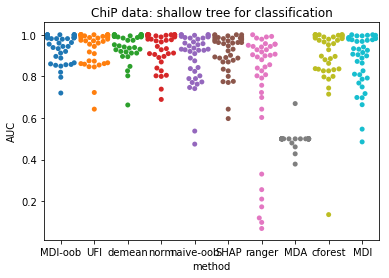

F:MDI-oob       0.938800
F:UFI           0.939000
F:demean        0.950200
F:norm          0.934600
F:naive-oob     0.888633
F:SHAP          0.912033
F:ranger        0.755000
F:MDA           0.497933
F:cforest       0.900433
F:MDI           0.877233
id             19.500000
dtype: float64


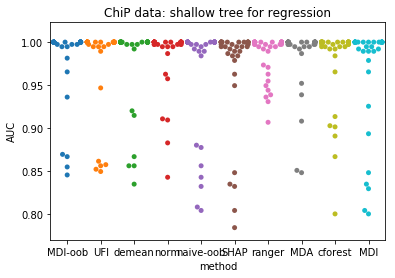

F:MDI-oob       0.982500
F:UFI           0.979767
F:demean        0.980800
F:norm          0.985500
F:naive-oob     0.971033
F:SHAP          0.972033
F:ranger        0.985467
F:MDA           0.986167
F:cforest       0.979400
F:MDI           0.970500
id             19.500000
dtype: float64


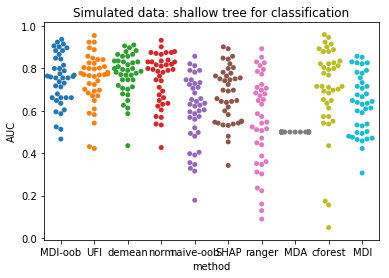

F:MDI-oob       0.748000
F:UFI           0.749000
F:demean        0.772667
F:norm          0.751111
F:naive-oob     0.597722
F:SHAP          0.676722
F:ranger        0.548556
F:MDA           0.500000
F:cforest       0.700889
F:MDI           0.631722
id             19.500000
dtype: float64


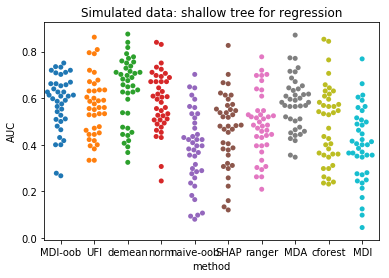

F:MDI-oob       0.581167
F:UFI           0.564111
F:demean        0.630722
F:norm          0.587833
F:naive-oob     0.384722
F:SHAP          0.462389
F:ranger        0.487889
F:MDA           0.576722
F:cforest       0.488333
F:MDI           0.396722
id             19.500000
dtype: float64


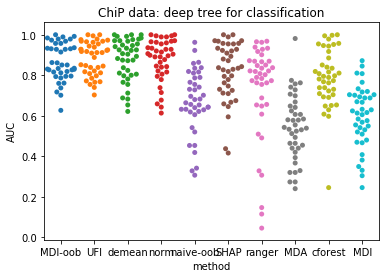

F:MDI-oob       0.865200
F:UFI           0.883767
F:demean        0.876800
F:norm          0.875667
F:naive-oob     0.669533
F:SHAP          0.820533
F:ranger        0.725733
F:MDA           0.542333
F:cforest       0.788333
F:MDI           0.596867
id             19.500000
dtype: float64


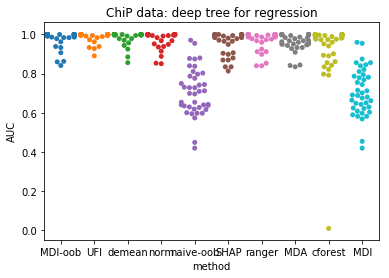

F:MDI-oob       0.979767
F:UFI           0.989200
F:demean        0.986667
F:norm          0.979200
F:naive-oob     0.706667
F:SHAP          0.962933
F:ranger        0.973800
F:MDA           0.965733
F:cforest       0.929000
F:MDI           0.705733
id             19.500000
dtype: float64


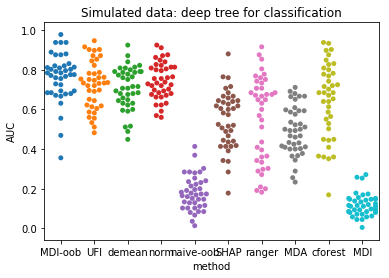

F:MDI-oob       0.762389
F:UFI           0.724278
F:demean        0.707667
F:norm          0.743556
F:naive-oob     0.178333
F:SHAP          0.548000
F:ranger        0.554778
F:MDA           0.493000
F:cforest       0.648889
F:MDI           0.117889
id             19.500000
dtype: float64


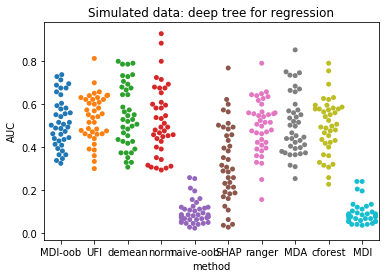

F:MDI-oob       0.519333
F:UFI           0.537111
F:demean        0.547778
F:norm          0.523444
F:naive-oob     0.097000
F:SHAP          0.325444
F:ranger        0.496111
F:MDA           0.506778
F:cforest       0.499444
F:MDI           0.092111
id             19.500000
dtype: float64


In [8]:
a = ['', 'ChiP', 'Simulated']
for tree_depth in ['shallow','deep']:
    for num in [1, 2]:
        for problem in ['classification', 'regression']:
            tmp = np.load('../intermediate/04_aggregate/{}{}/results_{}.npz'.format(problem, num, tree_depth))
            tmp2 = np.load('../intermediate/04_aggregate/{}{}/add_new_results_{}.npz'.format(problem, num, tree_depth))
            tmp3 = np.load('../intermediate/04_aggregate/{}{}/add_new_naive_results_{}.npz'.format(problem, num, tree_depth))
            tmp4 = np.load('../intermediate/04_aggregate/{}{}/add_new_demean_results_{}.npz'.format(problem, num, tree_depth))
            tmp5 = np.load('../intermediate/04_aggregate/{}{}/add_new_norm_results_{}.npz'.format(problem, num, tree_depth))
            debiased, gini, SHAP, mda = [tmp[x] for x in list(tmp)]
            new_gini, ufi = [tmp2[x] for x in list(tmp2)]
            _, naive = [tmp3[x] for x in list(tmp3)]
            _, demean = [tmp4[x] for x in list(tmp4)]
            _, norm = [tmp5[x] for x in list(tmp5)]
            tmp2 = pd.read_csv('../intermediate/04_aggregate_R_max_features_10/auc_df_{}{}_{}.csv'.format(problem, num, tree_depth))
            gini_R, ranger, cforest = np.array(tmp2.iloc[:, 1]), np.array(tmp2.iloc[:, 2]), np.array(tmp2.iloc[:, 3])
            out = np.array([debiased, ufi, demean, norm, naive, SHAP,ranger, mda, cforest, gini]).T
            #sn.swarmplot(out)
            to_plot = pd.DataFrame(out, columns=['F:MDI-oob', 'F:UFI', 'F:demean', 'F:norm', 'F:naive-oob', 'F:SHAP', 'F:ranger', 'F:MDA', 'F:cforest', 'F:MDI'])
            to_plot['id'] = to_plot.index
            df = pd.wide_to_long(to_plot, "F", i='id', j='method', sep=':',suffix='\D+').reset_index()
            sn.swarmplot(x='method', y = 'F', data=df)
            plt.title('{} data: {} tree for {}'.format(a[num], tree_depth, problem))
            #plt.xticks(list(range(1, 9)), ['MDI-oob', 'SHAP', 'ranger', 'MDA', 'cforest', 'MDI', 'new_gini', 'ufi'])
            plt.ylabel('AUC')
            plt.show()
            
            print(np.mean(to_plot))
            #print(gini)
            #print(gini_R)